In [3]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime
from datetime import timedelta  
from xgrads import open_CtlDataset
import geopandas as gpd
import rioxarray
import requests
from geocube.api.core import make_geocube

# domain
domain = 'BRIS'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# PATHS
# path to store files to 
OUTpath = '/nfs/attic/dfh/2020_NPRB/data/'
# Path to the SnowModel folder
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'

## rasterize the domain vector file 

In [4]:
#watershed data
ctlFile = SMpath+'/watershed/watershed.ctl'

wd = open_CtlDataset(ctlFile)
wd

<xarray.Dataset>
Dimensions:  (lat: 1228, lev: 1, lon: 949, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01
  * lev      (lev) float64 1.0
  * lat      (lat) float32 417000.0 418000.0 419000.0 ... 1643000.0 1644000.0
  * lon      (lon) float32 -771000.0 -770000.0 -769000.0 ... 176000.0 177000.0
Data variables:
    dir      (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    wshed    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    order    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
Attributes:
    title:    
    undef:    -9999.0
    pdef:     None

In [5]:
#assign spatial reference system
wd = wd.rename({'lon': 'x', 'lat': 'y'})
wd.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
wd

<xarray.Dataset>
Dimensions:      (lev: 1, time: 1, x: 949, y: 1228)
Coordinates:
  * time         (time) datetime64[ns] 2011-10-01
  * lev          (lev) float64 1.0
  * y            (y) float32 417000.0 418000.0 419000.0 ... 1643000.0 1644000.0
  * x            (x) float32 -771000.0 -770000.0 -769000.0 ... 176000.0 177000.0
    spatial_ref  int64 0
Data variables:
    dir          (time, lev, y, x) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    wshed        (time, lev, y, x) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    order        (time, lev, y, x) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
Attributes:
    title:         
    undef:         -9999.0
    pdef:          None
    grid_mapping:  spatial_ref

In [6]:
# save out watershed .tiff
h2sd = (wd.wshed).squeeze()
h2sd = h2sd.drop_vars(['lev','time'])
h2sd.rio.to_raster('/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/watershed_testdem9s.tif')
h2sd

<xarray.DataArray 'wshed' (y: 1228, x: 949)>
dask.array<getitem, shape=(1228, 949), dtype=float32, chunksize=(1228, 949), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float32 417000.0 418000.0 419000.0 ... 1643000.0 1644000.0
  * x            (x) float32 -771000.0 -770000.0 -769000.0 ... 176000.0 177000.0
    spatial_ref  int64 0
Attributes:
    comment:       watersheds
    storage:       0
    grid_mapping:  spatial_ref

In [7]:
# huc2 vector file
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
# projected coordinates
shpproj = shp.to_crs(domains[domain]['mod_proj'])
# add column to create a binary mask in rasterized version
shpproj['mask'] = 1

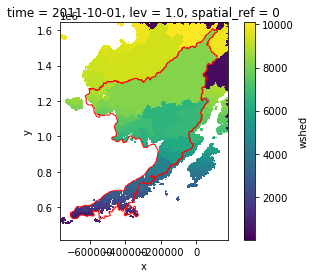

In [8]:
# plot
fig,ax = plt.subplots(figsize=[6,4])
wd.wshed.where(wd.wshed>0).plot(ax=ax)
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')

In [9]:
# reduce dimentionality
tmp = wd.dir.isel(lev=0,time=0)
tmp

<xarray.DataArray 'dir' (y: 1228, x: 949)>
dask.array<getitem, shape=(1228, 949), dtype=float32, chunksize=(1228, 949), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2011-10-01
    lev          float64 1.0
  * y            (y) float32 417000.0 418000.0 419000.0 ... 1643000.0 1644000.0
  * x            (x) float32 -771000.0 -770000.0 -769000.0 ... 176000.0 177000.0
    spatial_ref  int64 0
Attributes:
    comment:       flow direction
    storage:       0
    grid_mapping:  spatial_ref

In [10]:
# convert vector to raster
# reduce dimentionality of input raster for geocube function
tmp = wd.dir.isel(lev=0,time=0)

# convert vector data to raster
out_grid = make_geocube(
    vector_data = shpproj,
    measurements=['mask'],
    like=tmp,
    fill = 0,
)
out_grid

<xarray.Dataset>
Dimensions:      (x: 949, y: 1228)
Coordinates:
  * y            (y) float64 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * x            (x) float64 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
    spatial_ref  int64 0
Data variables:
    mask         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

In [11]:
# # save rasterized huc4 for later use
# path = OUTpath+'gis/'+domain+'/'+domain+'huc4_testDEM.tif'
# out_grid["mask"].rio.to_raster(path)

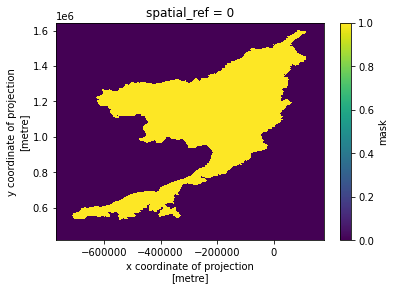

In [12]:
#visualize
out_grid.mask.plot()

## id watersheds in domain

In [13]:
# add huc4 mask to watershed data
wd['mask']=(('y', 'x'), out_grid.mask.values)
wd

<xarray.Dataset>
Dimensions:      (lev: 1, time: 1, x: 949, y: 1228)
Coordinates:
  * time         (time) datetime64[ns] 2011-10-01
  * lev          (lev) float64 1.0
  * y            (y) float32 417000.0 418000.0 419000.0 ... 1643000.0 1644000.0
  * x            (x) float32 -771000.0 -770000.0 -769000.0 ... 176000.0 177000.0
    spatial_ref  int64 0
Data variables:
    dir          (time, lev, y, x) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    wshed        (time, lev, y, x) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    order        (time, lev, y, x) float32 dask.array<chunksize=(1, 1, 1228, 949), meta=np.ndarray>
    mask         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:         
    undef:         -9999.0
    pdef:          None
    grid_mapping:  spatial_ref

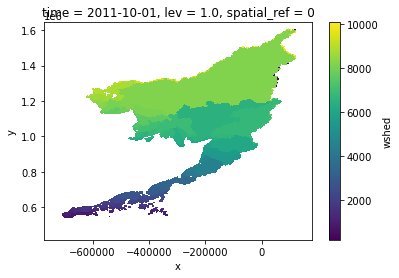

In [14]:
# clip watersheds to domain shapefile
# criteria:
# inside shapefile and have a flow direction greater than 0
wdslice = wd.wshed.where((wd.mask>0)&((wd.dir>0)))
wdslice.plot()

In [15]:
# get watershed numbers for watersheds that fall 
# primarily in the modeling domain 

# list of all watersheds
wdlist = np.unique(wd.wshed.values[~np.isnan(wd.wshed.values)])
# list of watersheds in huc4 
huc4wdlist = np.unique(wdslice.values[~np.isnan(wdslice.values)])
# total count of pixels in watershed
totalpx = []
# count of pixels per watershed within huc4
huc4px = []
for val in wdlist:
    totalpx.append(wd.wshed.where(wd.wshed==val).count().values.tolist())
    if val in huc4wdlist:
        huc4px.append(wdslice.where(wdslice==val).count().values.tolist())
    else:
        huc4px.append(0)
# build df with watershed ids and pixel counts     
data = {'wd':wdlist,
       'totalcount':totalpx,
       'huc4count':huc4px}
df = pd.DataFrame(data)

In [16]:
# add column to df with the fraction of pixels that fall within the domain
df['frac']=df.huc4count/df.totalcount
df = df.replace([np.inf],0)

In [17]:
len(df)

10097

In [18]:
df.sort_values(by=['totalcount'])

,wd,totalcount,huc4count,frac
5048,5048.0,2,0,0.000000
5080,5080.0,2,0,0.000000
5079,5079.0,2,0,0.000000
5078,5078.0,2,0,0.000000
5074,5074.0,2,0,0.000000
...,...,...,...,...
6771,6771.0,22114,21526,0.973411
6525,6525.0,30172,30171,0.999967
9378,9378.0,81655,325,0.003980
8221,8221.0,122197,121645,0.995483


552


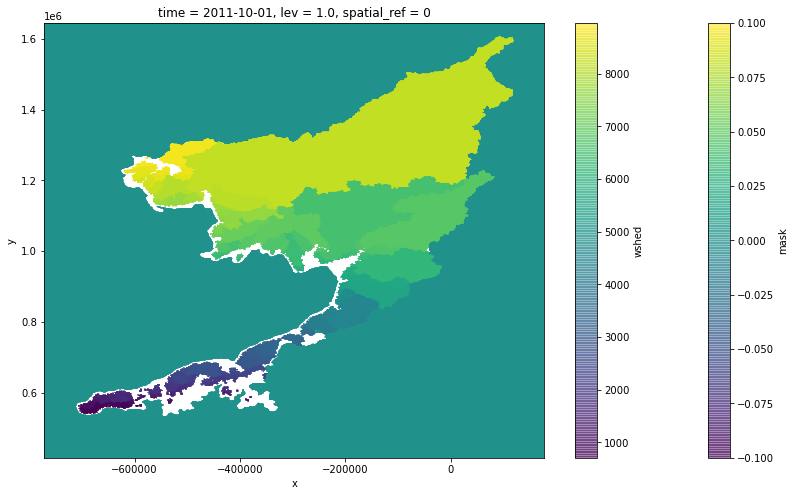

In [19]:
# create final watershed list based on threshold of watershed meeting criteria
# may need to adjust this later once run hf
thresh = 0.9
watersheds = df.wd.loc[df.frac>thresh].reset_index(drop=True)
print(len(watersheds))
#plot .9
fig,ax = plt.subplots(figsize=(14,8))
wd.mask.where(wd.mask==0).plot(ax=ax,alpha=.5)
wd.wshed.where(wd.wshed.isin(watersheds)).plot(ax=ax,alpha=0.5)


1207


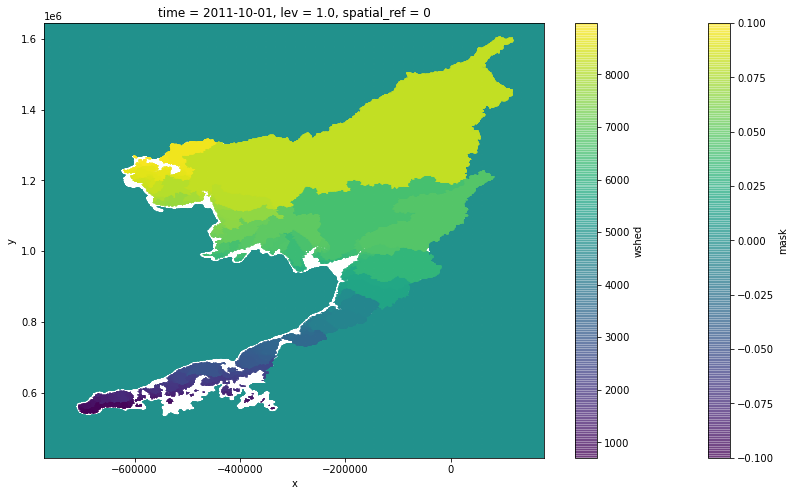

In [20]:
# create final watershed list based on threshold of watershed meeting criteria
# may need to adjust this later once run hf
thresh = 0.75
watersheds = df.wd.loc[df.frac>thresh].reset_index(drop=True)
print(len(watersheds))
#plot .75
fig,ax = plt.subplots(figsize=(14,8))
wd.mask.where(wd.mask==0).plot(ax=ax,alpha=.5)
wd.wshed.where(wd.wshed.isin(watersheds)).plot(ax=ax,alpha=0.5)


2312


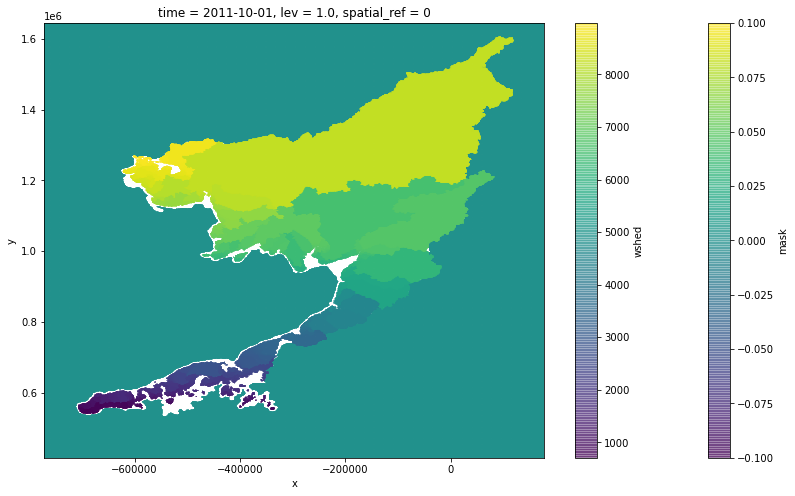

In [21]:
# create final watershed list based on threshold of watershed meeting criteria
# may need to adjust this later once run hf
thresh = 0.5
watersheds = df.wd.loc[df.frac>thresh].reset_index(drop=True)
print(len(watersheds))
#plot .5
fig,ax = plt.subplots(figsize=(14,8))
wd.mask.where(wd.mask==0).plot(ax=ax,alpha=.5)
wd.wshed.where(wd.wshed.isin(watersheds)).plot(ax=ax,alpha=0.5)


3791


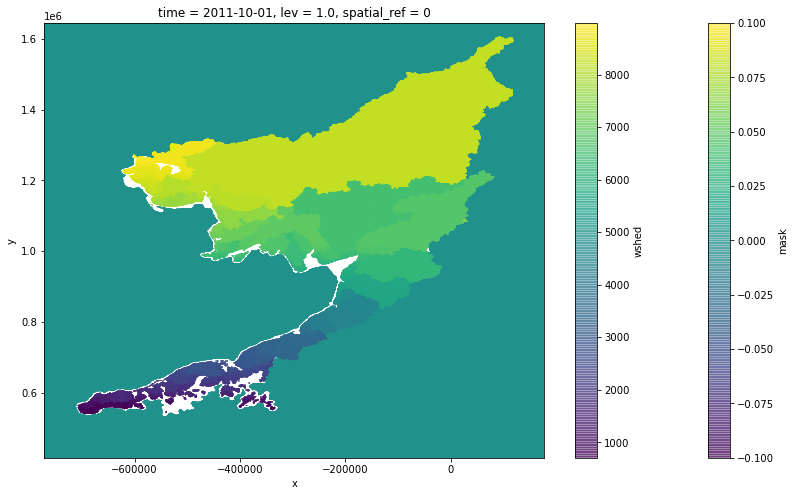

In [26]:
# create final watershed list based on threshold of watershed meeting criteria
# may need to adjust this later once run hf
thresh = 0.25
watersheds = df.wd.loc[df.frac>thresh].reset_index(drop=True)
print(len(watersheds))
#plot .25
fig,ax = plt.subplots(figsize=(14,8))
wd.mask.where(wd.mask==0).plot(ax=ax,alpha=.5)
wd.wshed.where(wd.wshed.isin(watersheds)).plot(ax=ax,alpha=0.5)


3811


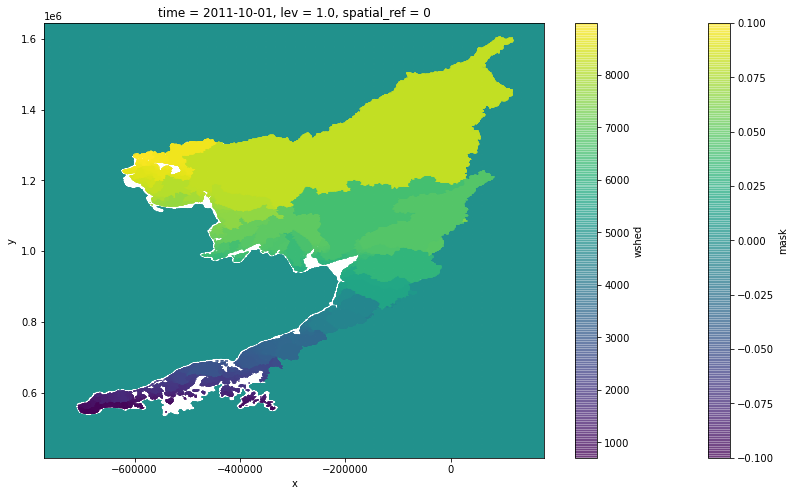

In [23]:
# create final watershed list based on threshold of watershed meeting criteria
# may need to adjust this later once run hf
thresh = 0.1
watersheds = df.wd.loc[df.frac>thresh].reset_index(drop=True)
print(len(watersheds))
#plot .1
fig,ax = plt.subplots(figsize=(14,8))
wd.mask.where(wd.mask==0).plot(ax=ax,alpha=.5)
wd.wshed.where(wd.wshed.isin(watersheds)).plot(ax=ax,alpha=0.5)


In [27]:
# save out list of watersheds 
# # save as .csv
watersheds.to_csv(OUTpath+'hf/'+domain+'/watersheds.csv')

In [28]:
min(watersheds),max(watersheds)

(704.0, 8983.0)

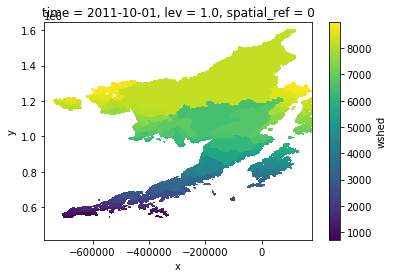

In [29]:
wd.wshed.where((wd.wshed<max(watersheds))&(wd.wshed>min(watersheds))).plot()

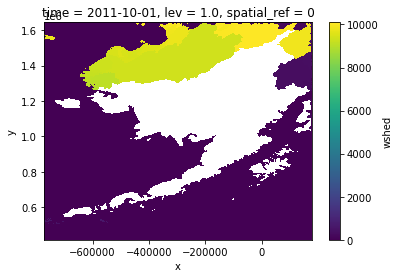

In [30]:
wd.wshed.where((wd.wshed>max(watersheds))|(wd.wshed<min(watersheds))).plot()